# Implementation of the Schmidl and Cox algorithm for frame synchronization in Python

This notebook is an implementation of the Schmild and Cox synchronization algorithm for OFDM. The algorithm is described in the paper "Robust Synchronization Techniques for OFDM Systems" by Schmild and Cox. The algorithm is based on the correlation of the received signal with itself.

This notebook is based on the following references:
1. Schmild and Cox, "Robust Synchronization Techniques for OFDM Systems", IEEE Transactions on Communication, 1997.
2. https://dspillustrations.com/pages/posts/misc/schmidlcox-synchronization-for-ofdm.html

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from collections import defaultdict

# Seed for reproducibility of signal and noise generation
random_seed = 64
generator = np.random.default_rng(random_seed)

# Folder to save the plots
folder = "../../presentables/meetings/meeting6/schmidl_cox_plots/"

## Signal generation

Schmild and Cox propose a synchronization algorithm based on a specific frame structure. The frame begins with a special symbol called **preamble**, which consists of two repeated parts, prepended by a cycle prefix (CP). The following figure shows the frame structure used in this notebook.


```txt
+----+---------+---------+----+---------------+----+---------------+----+---------------+
| CP |    A    |    A    | CP |    payload    | CP |    payload    | CP |    payload    |
+----+---------+---------+----+---------------+----+---------------+----+---------------+
|<------ Preamble ------>|<----------------------- N OFDM Symbols --------------------->|
```

Note that the symbol A has only data (wich can be created with a peudonoice sequence) on even frequencies, while odd frequency only contains 0. This makes the A symbol 2-periodic in the time-domain, due to DFT properties.

In [2]:
## Define the OFDM parameters
class OFDM: pass
ofdm = OFDM()

ofdm.K = 1024                   # Number of OFDM subcarriers
ofdm.CP = 128                   # Number of samples in the cyclic prefix
ofdm.ofdmSymbolsPerFrame = 3    # N, number of OFDM symbols in each frame
ofdm.L = ofdm.K // 2            # Parameter L, denotes the length of one repeated part of the preamble

We start by generating the preamble and the payload symbols.
The preamble is generated by having noise data only on even frequencies and zeros on odd frequencies. This makes it 2-periodic in the time domain, due to DFT properties.
The payload is generated by having random data on all frequencies. We consider here having 3 OFDM symbols in the payload, but this can be changed by changing the variable `ofdm.ofdmSymbolsPerFrame` in the code above.

In [3]:
## OFDM helper functions
def random_quam(ofdm: OFDM) -> np.ndarray:
    """ Generate random QAM symbols of length ofdm.K """
    quam = np.array([1 + 1j, 1 - 1j, -1 + 1j, -1 - 1j]) / np.sqrt(2)    # QAM symbols (normalized to unit power)
    return quam[generator.integers(0, 4, ofdm.K)]                       # Generate random QAM symbols       

def generate_preamble_OFDM_symbol(ofdm: OFDM) -> np.ndarray:
    """ Generate the preamble sequence """
    quam_preamble = random_quam(ofdm)   # Generate random QAM symbols
    quam_preamble[1::2] = 0             # Zero out odd-indexed subcarriers. This will create a 2-periodic time-domain preamble
    return quam_preamble
    
    
def modulate_OFDM_symbol(ofdm: OFDM, symbol: np.ndarray, insertCP: bool = True) -> np.ndarray:
    """ Modulate an OFDM symbol """
    fd_data = np.fft.ifft(symbol) * np.sqrt(ofdm.K)         # Perform the IFFT and scale the data
    if insertCP:
        return np.hstack((fd_data[-ofdm.CP:], fd_data))     # Insert the cyclic prefix
    else:
        return fd_data
    

def generate_OFDM_frame(ofdm: OFDM) -> np.ndarray:
    """ Generate an OFDM frame """
    # Preamble
    preamble_f = generate_preamble_OFDM_symbol(ofdm)
    preamble = modulate_OFDM_symbol(ofdm, preamble_f)    
    
    # Payload
    payload = np.hstack([modulate_OFDM_symbol(ofdm, random_quam(ofdm)) for _ in range(ofdm.ofdmSymbolsPerFrame)]) if ofdm.ofdmSymbolsPerFrame > 0 else np.array([])
    
    return np.hstack((preamble, payload))

In [4]:
x = generate_OFDM_frame(ofdm)

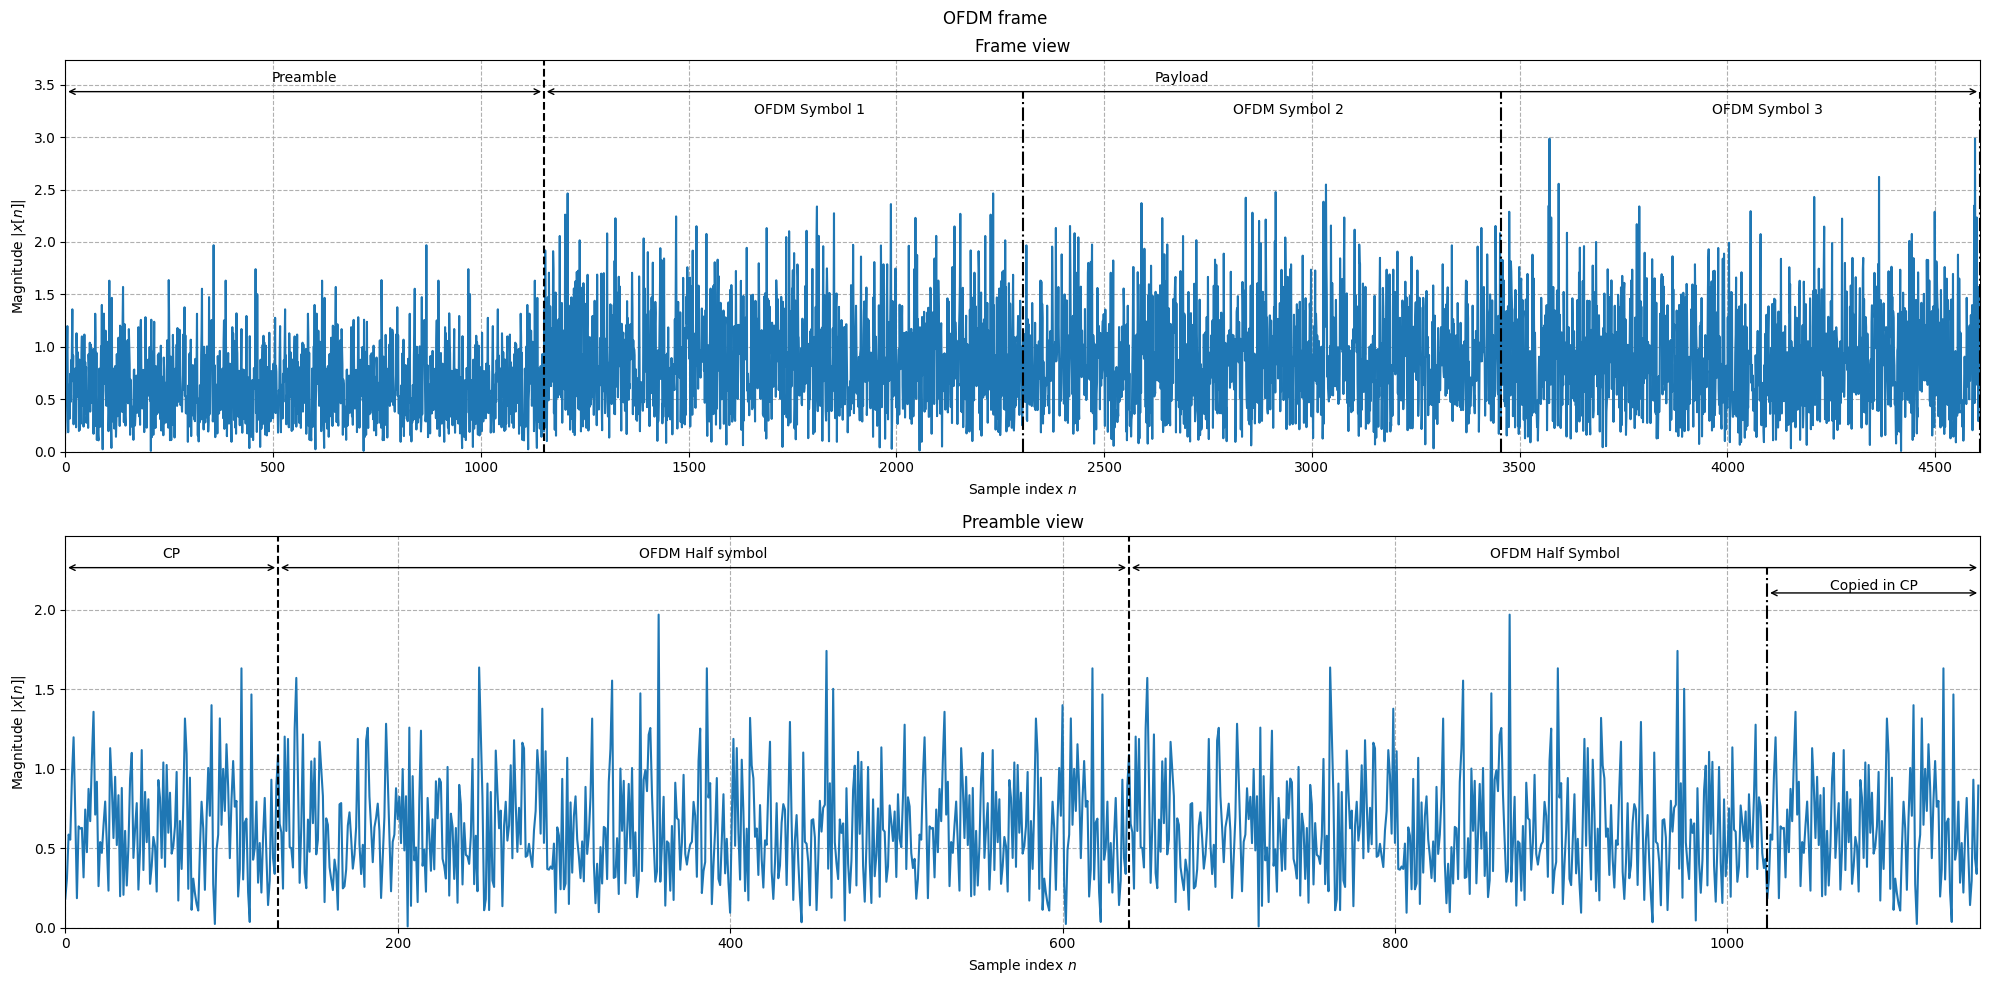

In [5]:
# Figure parameters
global_info_height = lambda x: max(abs(x)) * 1.18
global_symbol_height_lines = lambda x: max(abs(x)) * 1.15
ofdm_symbol_height = lambda x: max(abs(x)) * 1.08


# Plot the OFDM frame
fig = plt.figure(figsize=(20, 10))
fig.suptitle("OFDM frame")


# Above plot - frame view
plt.subplot(2, 1, 1)
plt.title("Frame view")
plt.plot(abs(x))
plt.xlabel("Sample index $n$")
plt.ylabel("Magnitude $|x[n]|$")
plt.xlim(0, len(x))
plt.ylim(0, max(abs(x)) * 1.25)
plt.xticks(np.arange(0, len(x), 500), np.arange(0, len(x), 500))

# Preable annotation
plt.text((ofdm.CP + ofdm.K) // 2, global_info_height(x), "Preamble", horizontalalignment='center')
plt.annotate("", xy=(ofdm.CP + ofdm.K, global_symbol_height_lines(x)), xytext=(0, global_symbol_height_lines(x)), arrowprops=dict(arrowstyle="<->"))
plt.axvline(x=ofdm.CP + ofdm.K, linestyle='--', color='black')

# Payload annotation
plt.text(ofdm.CP + ofdm.K + (ofdm.ofdmSymbolsPerFrame * ofdm.K) // 2, global_info_height(x), "Payload", horizontalalignment='center')
plt.annotate("", xy=(ofdm.CP + ofdm.K + ofdm.ofdmSymbolsPerFrame * (ofdm.K + ofdm.CP), global_symbol_height_lines(x)), xytext=(ofdm.CP + ofdm.K, global_symbol_height_lines(x)), arrowprops=dict(arrowstyle="<->"))

# Anotations of each OFDM symbol
for i in range(1, ofdm.ofdmSymbolsPerFrame + 1):
    plt.vlines(x=ofdm.CP + ofdm.K + i * (ofdm.K + ofdm.CP), ymin=0, ymax=global_symbol_height_lines(x), linestyle='-.', color='black')
    plt.text(ofdm.CP + ofdm.K + i * (ofdm.K + ofdm.CP) - ofdm.K // 2, ofdm_symbol_height(x), f"OFDM Symbol {i}", horizontalalignment='center')

plt.grid(True, linestyle='--')


# Below plot - Preable view
plt.subplot(2, 1, 2)
plt.title("Preamble view")
plt.plot(abs(x[:ofdm.CP + ofdm.K]))
plt.xlabel("Sample index $n$")
plt.ylabel("Magnitude $|x[n]|$")
plt.xlim(0, ofdm.CP + ofdm.K)
plt.ylim(0, max(abs(x[:ofdm.CP + ofdm.K])) * 1.25)

# Cylic prefix annotation
plt.text(ofdm.CP // 2, global_info_height(x[:ofdm.CP + ofdm.K]), "CP", horizontalalignment='center')
plt.annotate("", xy=(ofdm.CP, global_symbol_height_lines(x[:ofdm.CP + ofdm.K])), xytext=(0, global_symbol_height_lines(x[:ofdm.CP + ofdm.K])), arrowprops=dict(arrowstyle="<->"))
plt.axvline(x=ofdm.CP, linestyle='--', color='black')

# Symbol annotation - part 1
plt.text(ofdm.CP + ofdm.L // 2, global_info_height(x[:ofdm.CP + ofdm.K]), "OFDM Half symbol", horizontalalignment='center')
plt.annotate("", xy=(ofdm.CP + ofdm.L, global_symbol_height_lines(x[:ofdm.CP + ofdm.K])), xytext=(ofdm.CP, global_symbol_height_lines(x[:ofdm.CP + ofdm.K])), arrowprops=dict(arrowstyle="<->"))
plt.axvline(x=ofdm.CP + ofdm.L, linestyle='--', color='black')

# Second symbol part 2
plt.text(ofdm.CP + ofdm.L + ofdm.L // 2, global_info_height(x[:ofdm.CP + ofdm.K]), "OFDM Half Symbol", horizontalalignment='center')
plt.annotate("", xy=(ofdm.CP + 2 * ofdm.L, global_symbol_height_lines(x[:ofdm.CP + ofdm.K])), xytext=(ofdm.CP + ofdm.L, global_symbol_height_lines(x[:ofdm.CP + ofdm.K])), arrowprops=dict(arrowstyle="<->"))

# Part taken for the cyclic prefix
plt.text(ofdm.CP + ofdm.L + ofdm.L - ofdm.CP // 2, ofdm_symbol_height(x[:ofdm.CP + ofdm.K]), "Copied in CP", horizontalalignment='center')
plt.annotate("", xy=(ofdm.CP + 2 * ofdm.L, ofdm_symbol_height(x[:ofdm.CP + ofdm.K]) * 0.99), xytext=(ofdm.CP + 2 * ofdm.L - ofdm.CP, ofdm_symbol_height(x[:ofdm.CP + ofdm.K]) * 0.99), arrowprops=dict(arrowstyle="<->"))
plt.vlines(x=ofdm.CP + 2 * ofdm.L - ofdm.CP, ymin=0, ymax=global_symbol_height_lines(x[:ofdm.CP + ofdm.K]), linestyle='-.', color='black')

plt.grid(True, linestyle='--')
plt.tight_layout()

plt.savefig(folder + "OFDM_frame.pdf")


The above figure shows the frame structure used in this notebook. In the complete frame view, we distinguish the preamble and the payload. The preamble view shows the two repeated parts of the preamble, as well as the cyclic prefix (CP) that is added to the preamble by taking the last `ofdm.CP` samples and prepending them to the preamble. 

## Channel simulation

The channel is simulated by adding white Gaussian noise and a timing offset to the transmitted signal. The received signal can be expressed as: $$r(d) = x(d - \tau) + n(d)$$ where $x(d)$ is the transmitted signal, $\tau$ is the timing offset, and $n(d)$ is the white Gaussian noise. The timing offset is simulated by shifting the received signal by a number of samples. The white Gaussian noise is generated using random numbers following a normal distribution with zero mean and unit variance.

In [6]:
## Channel simulation functions
def addCFO(signal, cfo):
    """ Add carrier frequency offset """
    return signal * np.exp(2j * np.pi * cfo * np.arange(len(signal)))

def addSTO(signal, sto):
    """ Add sample timing offset """
    return np.hstack([np.zeros(sto), signal])

def addNoise(signal, sigma2):
    """ Add AWGN noise """
    noise = np.sqrt(sigma2 / 2) * (generator.standard_normal(len(signal)) + 1j * generator.standard_normal(len(signal)))
    return signal + noise

def addChannel(signal, h):
    """ Add multipath impulse response """
    return sp.signal.lfilter(h, (1, ), signal)

In [7]:
## Adding STO and noice to the transmitted signal 
sto = 473
noise = 0.5
r = addNoise(addSTO(x, sto), noise)

## Timing synchronization

The goal of the timing synchronization is to estimate the timing offset $\hat{\tau}$ that was added to the received signal. To this end, we will use the Schmidl and Cox algorithm that search for a specific symbol where the first half is identical to the second half. This aims to detect the preamble that was added to the transmitted signal.

In [8]:
metric_size = len(r) - 2 * ofdm.L
d_set = np.arange(0, metric_size)

In [9]:
def plot_metrics_on_labelled_figure(signal: np.ndarray, P: np.ndarray, R: np.ndarray, M: np.ndarray, sto: int, ofdm: OFDM):
    """ Plot the metrics on a labelled figure """
    plt.plot(np.abs(signal), label="Received signal $r$")
    plt.plot(np.abs(P), label="$P(d)$ metric")
    plt.plot(np.abs(R), label="$R(d)$ metric")
    plt.plot(np.abs(M), label="$M(d)$ metric")
    plt.legend(loc='upper right')
    plt.xlabel("Sample index $n$")
    plt.ylabel("Magnitude $|x[n]|$")
    plt.xlim(0, sto + 2 * ofdm.CP + 2 * ofdm.K)
    plt.ylim(0, 1.2)

    # STO annotation
    plt.text(sto // 2, 1.12, "STO", horizontalalignment='center')
    plt.annotate("", xy=(sto, 1.11), xytext=(0, 1.11), arrowprops=dict(arrowstyle="<->"))
    plt.axvline(x=sto, linestyle='--', color='black')

    # Preamble annotation
    plt.text(sto + ofdm.CP + ofdm.K // 2, 1.12, "Preamble", horizontalalignment='center')
    plt.annotate("", xy=(sto + ofdm.CP + ofdm.K, 1.11), xytext=(sto, 1.11), arrowprops=dict(arrowstyle="<->"))
    plt.axvline(x=sto + ofdm.CP + ofdm.K, linestyle='--', color='black')

    # Cyclic prefix in preamble annotation
    plt.text(sto + ofdm.CP // 2, 1.06, "CP", horizontalalignment='center')
    plt.annotate("", xy=(sto + ofdm.CP, 1.05), xytext=(sto, 1.05), arrowprops=dict(arrowstyle="<->"))
    plt.vlines(x=sto + ofdm.CP, ymin=0, ymax=1.11, linestyle='-.', color='black')

    # Payload annotation
    plt.text(sto + ofdm.CP + ofdm.K + (ofdm.CP + ofdm.K) // 2, 1.12, "Payload", horizontalalignment='center')
    plt.annotate("", xy=(sto + 2 * ofdm.CP + 2 * ofdm.K, 1.11), xytext=(sto + ofdm.CP + ofdm.K, 1.11), arrowprops=dict(arrowstyle="<-"))

    plt.grid(True, linestyle='--')

### Non-causal formulation

#### Original algorithm

In the original paper, Schmidl and Cox introduce the following metric to detect the preamble:
$$P(d) = \sum_{m=0}^{L-1} r^*(d+m) \cdot r(d+m+L)$$
where $L$ is the length of the preamble. They add the received energy for the second half-symbol defined as:
$$R(d) = \sum_{m=0}^{L-1} |r(d+m+L)|^2$$
The timing metric is then defined as:
$$M(d) = \frac{|P(d)|^2}{(R(d))^2}$$

In [10]:
## Original formulation
# P(d) metric
P = np.zeros(metric_size, dtype=complex)
for i, d in enumerate(d_set):
    P[i] = sum(r[d + m].conj() * r[d + m + ofdm.L] for m in range(0, ofdm.L))

# R(d) metric
R = np.zeros(metric_size, dtype=complex)
for i, d in enumerate(d_set):
    R[i] = sum(abs(r[d + m + ofdm.L])**2 for m in range(ofdm.L))
    
# M(d) metric
M = np.divide(abs(P)**2, R**2, out=np.zeros_like(abs(P)**2, dtype=complex), where=R != 0)

#### Iterative formulation

However, those metrics are not easy to compute. It is possible to derive an iterative algorithm to compute both metrics. Note that the initial value of those metrics still needs to be computed by the above equations. The iterative algorithm is given by:
$$P(d+1) = P(d) + r^*(d+L) \cdot r(d+2L) - r^*(d) \cdot r(d+L)$$
$$R(d+1) = R(d) + |r(d+2L)|^2 - |r(d+L)|^2$$

In [11]:
## Iterative formulation
# P(d) metric
P_rec = np.zeros(metric_size, dtype=complex)
P_rec[0] = sum(r[m].conj() * r[m + ofdm.L] for m in range(0, ofdm.L))
for d in d_set[:-1]:
    P_rec[d + 1] = P_rec[d] + r[d + ofdm.L].conj() * r[d + 2 * ofdm.L] - r[d].conj() * r[d + ofdm.L]
    
# R(d) metric
R_rec = np.zeros(metric_size, dtype=complex)
R_rec[0] = sum(abs(r[m + ofdm.L])**2 for m in range(ofdm.L))
for d in d_set[:-1]:
    R_rec[d + 1] = R_rec[d] + abs(r[d + 2 * ofdm.L])**2 - abs(r[d + ofdm.L])**2
    
# M(d) metric
M_rec = np.divide(abs(P_rec)**2, R_rec**2, out=np.zeros_like(abs(P_rec)**2, dtype=complex), where=R_rec != 0)

We could also evaluate the impact defining $P(d = 0) = 0$. This leads to a simpler implementation and marginal impact on the final result.

In [12]:
## Iterative formulation - with 0 initialization of P(d) metric
# P(d) metric
P_rec_0 = np.zeros(metric_size, dtype=complex)
for d in d_set[:-1]:
    P_rec_0[d + 1] = P_rec_0[d] + r[d + ofdm.L].conj() * r[d + 2 * ofdm.L] - r[d].conj() * r[d + ofdm.L]
    
# M(d) metric
M_rec_0 = np.divide(abs(P_rec_0)**2, R_rec**2, out=np.zeros_like(abs(P_rec_0)**2, dtype=complex), where=R_rec != 0)

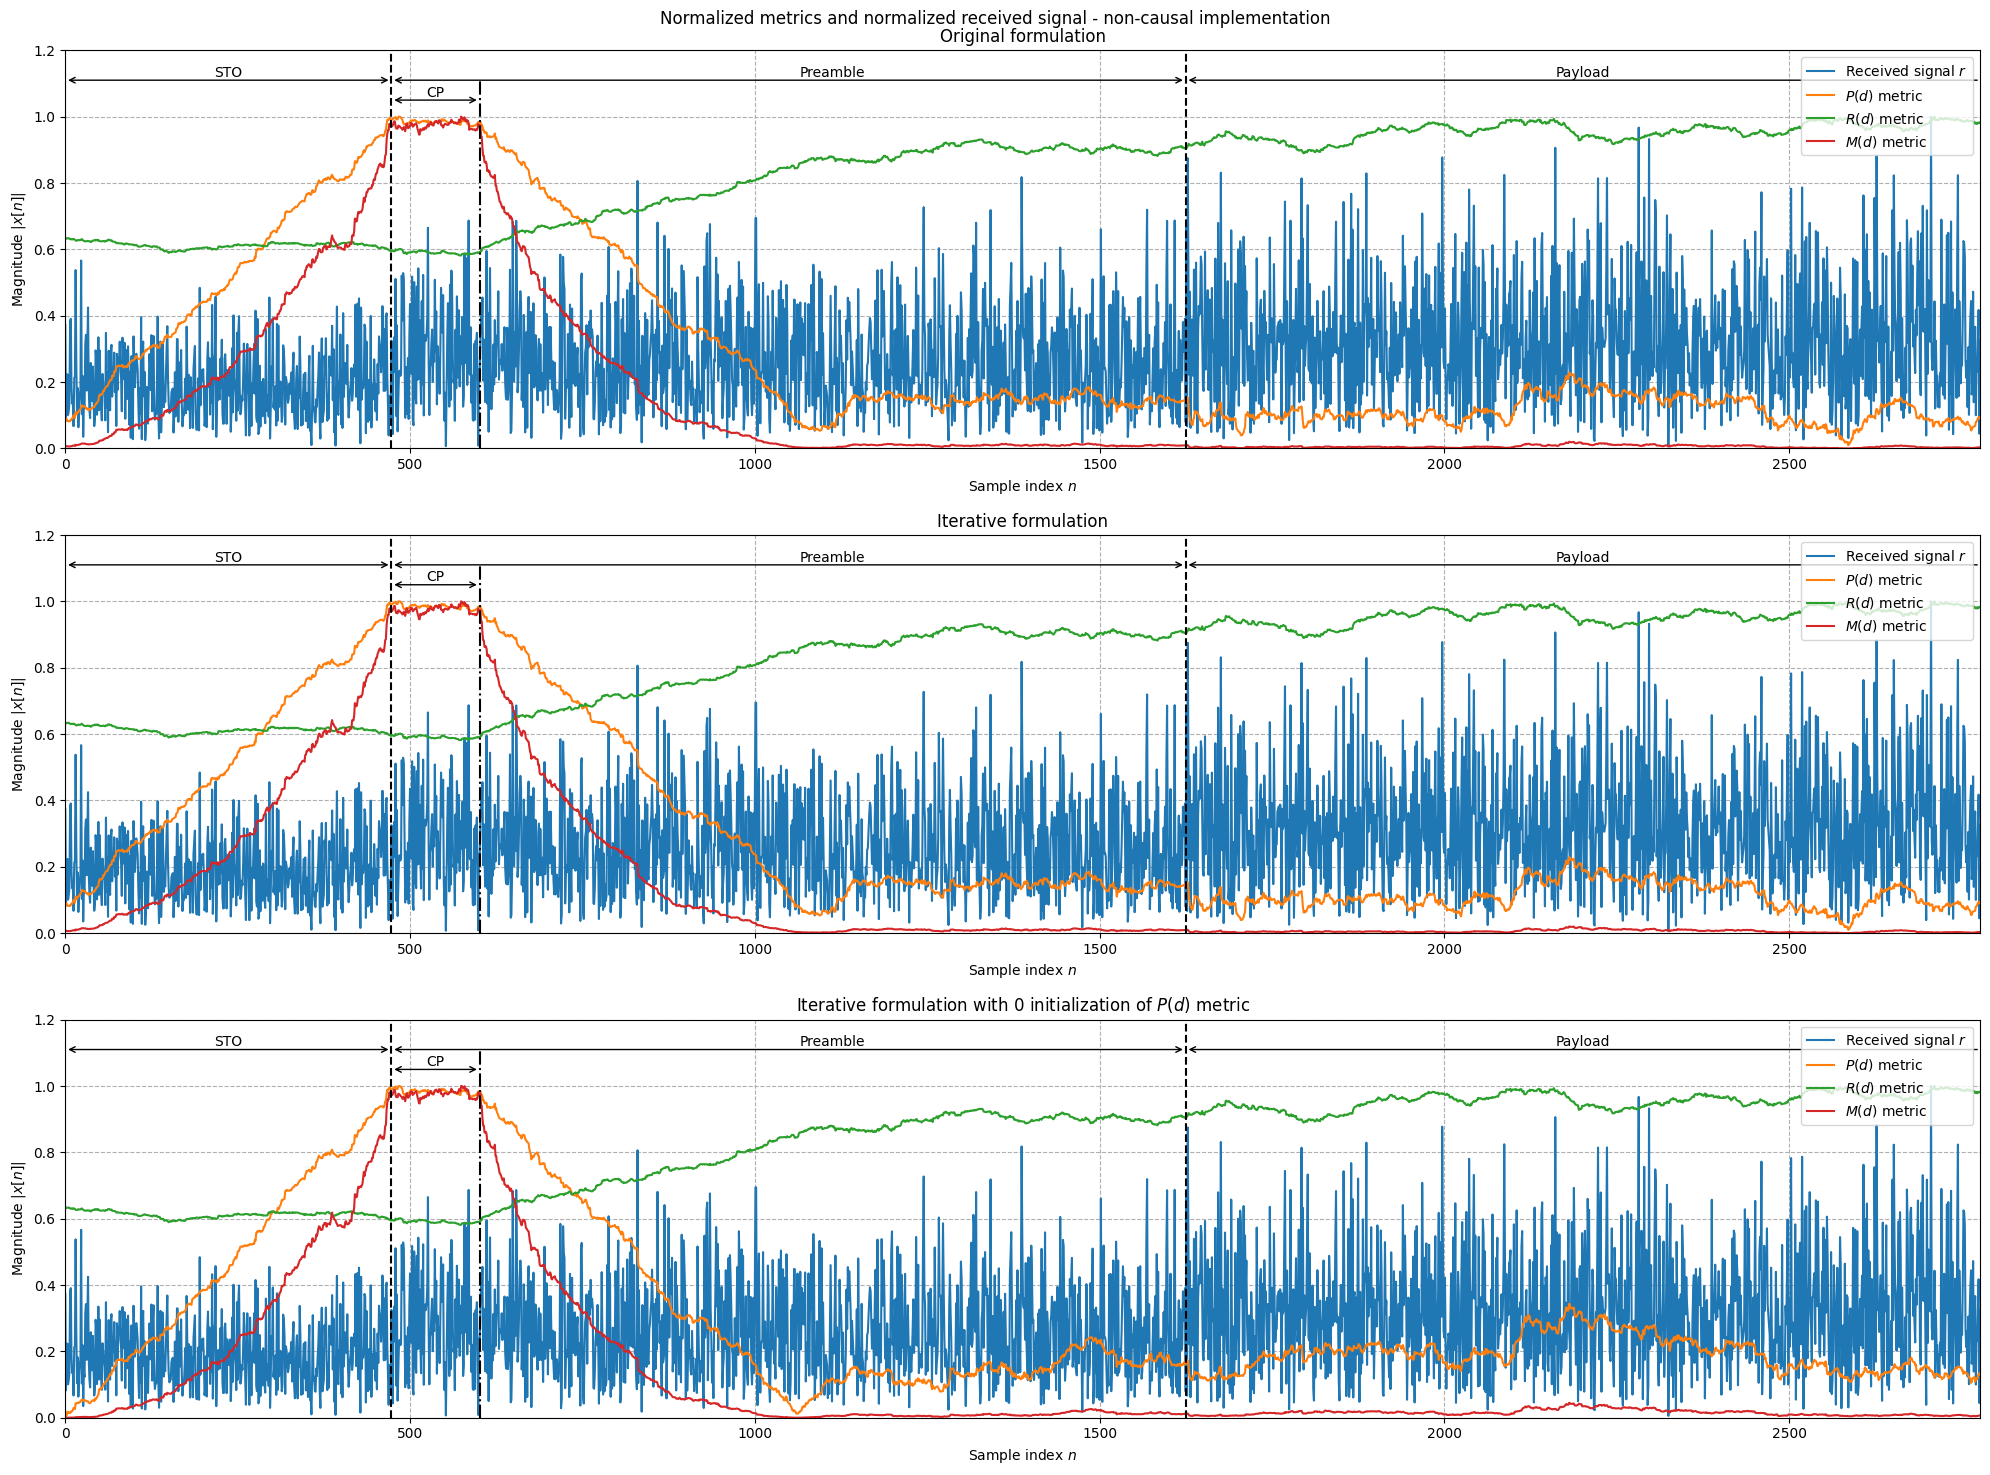

In [13]:
# Normalize the metrics and the received signal
r_norm = r / np.max(abs(r))

P_norm = P / np.max(abs(P))
R_norm = R / np.max(abs(R))
M_norm = M / np.max(abs(M))

P_rec_norm = P_rec / np.max(abs(P_rec))
R_rec_norm = R_rec / np.max(abs(R_rec))
M_rec_norm = M_rec / np.max(abs(M_rec))

P_rec_0_norm = P_rec_0 / np.max(abs(P_rec_0))
M_rec_0_norm = M_rec_0 / np.max(abs(M_rec_0))

# Plot the metrics
fig = plt.figure(figsize=(20, 15))
fig.suptitle("Normalized metrics and normalized received signal - non-causal implementation")
plt.subplot(3, 1, 1)
plt.title("Original formulation")
plot_metrics_on_labelled_figure(r_norm, P_norm, R_norm, M_norm, sto, ofdm)
plt.subplot(3, 1, 2)
plt.title("Iterative formulation")
plot_metrics_on_labelled_figure(r_norm, P_rec_norm, R_rec_norm, M_rec_norm, sto, ofdm)
plt.subplot(3, 1, 3)
plt.title("Iterative formulation with 0 initialization of $P(d)$ metric")
plot_metrics_on_labelled_figure(r_norm, P_rec_0_norm, R_rec_norm, M_rec_0_norm, sto, ofdm)
plt.tight_layout()

plt.savefig(folder + "metrics.pdf")


### Causal formulation

However, the above formulation is not causal, as it requires future samples to compute the metric. To make it causal, we can delay the computation of the metric by $2L$ samples (which is the length of one OFDM symbol). This leads to the following causal formulation:
$$P(d+1) = P(d) + r^*(d-L) \cdot r(d) - r^*(d-2L) \cdot r(d-L)$$
$$R(d+1) = R(d) + |r(d)|^2 - |r(d - L)|^2$$
We chose here to define $P(d = 0) = 0$. To compute $R(d = 0)$, we can use the following equation:
$$R(d = 0) = \sum_{m=-2L + 1}^{L} |r(m)|^2$$

In [14]:
## Keeping in memory the last 2L samples of the received signal and calculating the metrics
metric_size = len(r) - 2 * ofdm.L
d_set = np.arange(0, metric_size)

# P(d) metric - initialization at 0
P_caus = np.zeros(metric_size, dtype=complex)
for d in d_set[2 * ofdm.L:-1]:
    P_caus[d + 1] = P_caus[d] + r[d - ofdm.L].conj() * r[d] - r[d - 2 * ofdm.L].conj() * r[d - ofdm.L]
    
# R(d) metric
R_caus = np.zeros(metric_size, dtype=complex)
R_caus[2 * ofdm.L] = sum(abs(r[m])**2 for m in range(-2 * ofdm.L + 1, -ofdm.L + 1))
for d in d_set[2 * ofdm.L:-1]:
    R_caus[d + 1] = R_caus[d] + abs(r[d])**2 - abs(r[d - ofdm.L])**2
    
# M(d) metric
M_caus = np.divide(abs(P_caus)**2, R_caus**2, out=np.zeros_like(abs(P_caus)**2, dtype=complex), where=R_caus != 0)

Both $P(d)$ and $R(d)$ can be written as a linear IIR filter operation. 
Indeed, by introducing $v(d) = r^*(d-L) \cdot r(d)$, we rewrite the above equations for $P(d)$ as:
$$P(d+1) = P(d) + v(d) - v(d-L)$$

In [15]:
## Use filter to calculate the metrics
b = np.zeros(ofdm.L, dtype=complex); b[0] = 1; b[-1] = -1
a = (1, -1)

# P(d) metric
mult = r[ofdm.L:].conj() * r[:-ofdm.L]
mult = np.hstack([np.zeros(ofdm.L), mult])
P_filter = sp.signal.lfilter(b, a, mult)

# R(d) metric
square = np.abs(r)**2
R_filter = sp.signal.lfilter(b, a, square)

# M(d) metric
M_filter = np.divide(np.abs(P_filter)**2, R_filter**2, out=np.zeros_like(np.abs(P_filter)**2, dtype=complex), where=R_filter != 0)


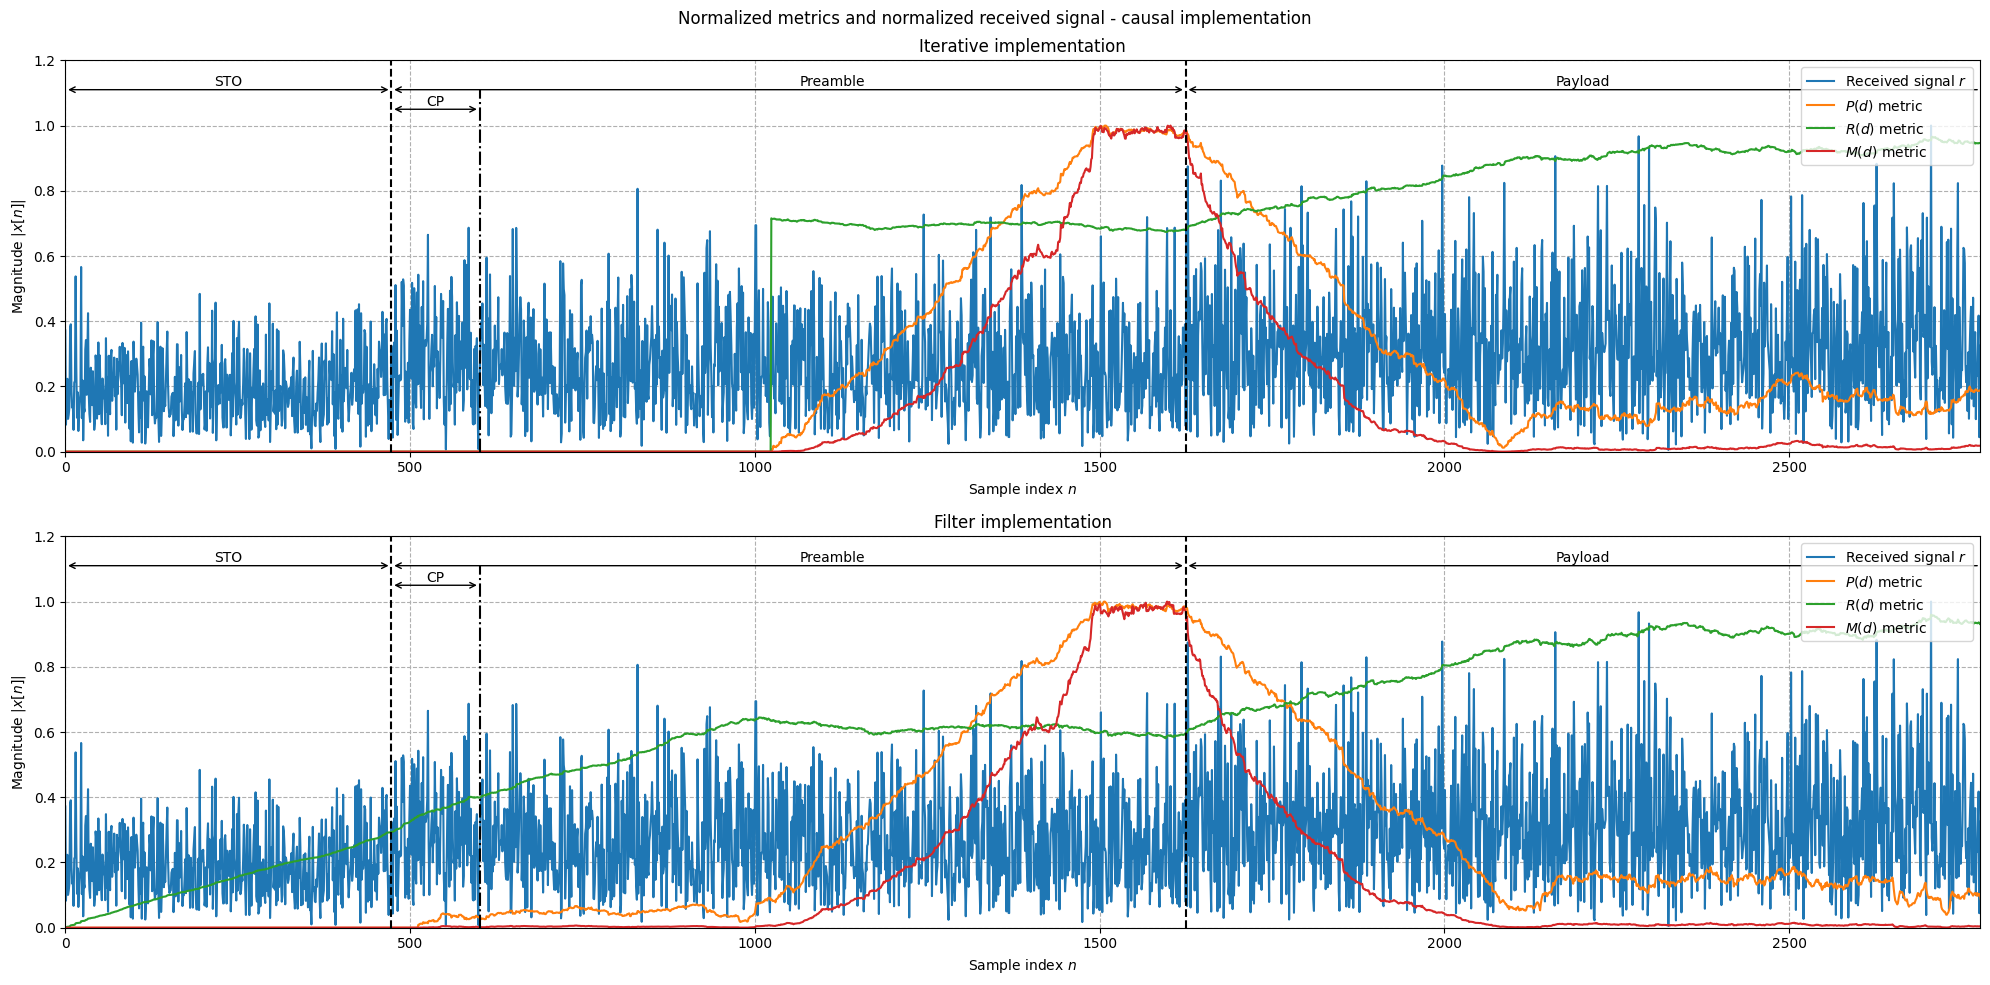

In [16]:
# Normalize the metrics and the received signal
r_norm = r / np.max(abs(r))

P_caus_norm = P_caus / np.max(abs(P_caus))
R_caus_norm = R_caus / np.max(abs(R_caus))
M_caus_norm = M_caus / np.max(abs(M_caus))

P_filter_norm = P_filter / np.max(abs(P_filter))
R_filter_norm = R_filter / np.max(abs(R_filter))
M_filter_norm = M_filter / np.max(abs(M_filter))

fig = plt.figure(figsize=(20, 10))
fig.suptitle("Normalized metrics and normalized received signal - causal implementation")
plt.subplot(2, 1, 1)
plt.title("Iterative implementation")
plot_metrics_on_labelled_figure(r_norm, P_caus_norm, R_caus_norm, M_caus_norm, sto, ofdm)
plt.subplot(2, 1, 2)
plt.title("Filter implementation")
plot_metrics_on_labelled_figure(r_norm, P_filter_norm, R_filter_norm, M_filter_norm, sto, ofdm)
plt.tight_layout()

plt.savefig(folder + "metrics_causal.pdf")

### Initialization phase

The above equations require an exact value for $P(d = 0)$ and $R(d = 0)$. However, by observing that both metrics only depend on the $2L$ last received samples, we can ignore the computation of an exact value for $P(d = 0)$ and $R(d = 0)$ if we assume an initialization phase of (at least) $2L$ samples. We will now consider this assumption in the following implementation.

This leads to the hypothesis that the timing offset $\tau$ is greater than $2L$ samples or, in other words, that the received signal will be captured, at least, $2L$ samples after the start of the algorithm.

In [17]:
## Adding 2L noise samples before the received signal to add more STO
sto = 2 * ofdm.L + 473
noise = 0.5

added_noise_signal = addNoise(np.zeros(2 * ofdm.L), noise)
r = np.hstack([added_noise_signal, r])

In [18]:
## Re-calculate the metrics size
metric_size = len(r) - 2 * ofdm.L
d_set = np.arange(0, metric_size)

In [19]:
## Keeping in memory the last 2L samples of the received signal and calculating the metrics
metric_size = len(r) - 2 * ofdm.L
d_set = np.arange(0, metric_size)

# P(d) metric - initialization at 0
P_caus = np.zeros(metric_size, dtype=complex)
for d in d_set[:-1]:
    p_d_minus_L = r[d - ofdm.L] if d - ofdm.L >= 0 else 0j
    p_d_minus_2L = r[d - 2 * ofdm.L] if d - 2 * ofdm.L >= 0 else 0j
    P_caus[d + 1] = P_caus[d] + np.conj(p_d_minus_L) * r[d] - np.conj(p_d_minus_2L) * p_d_minus_L
    
# R(d) metric
R_caus = np.zeros(metric_size, dtype=complex)
for d in d_set[:-1]:
    r_d_minus_L = r[d - ofdm.L] if d - ofdm.L >= 0 else 0j
    R_caus[d + 1] = R_caus[d] + abs(r[d])**2 - abs(r_d_minus_L)**2
    
# M(d) metric
M_caus = np.divide(abs(P_caus)**2, R_caus**2, out=np.zeros_like(abs(P_caus)**2, dtype=complex), where=R_caus != 0)

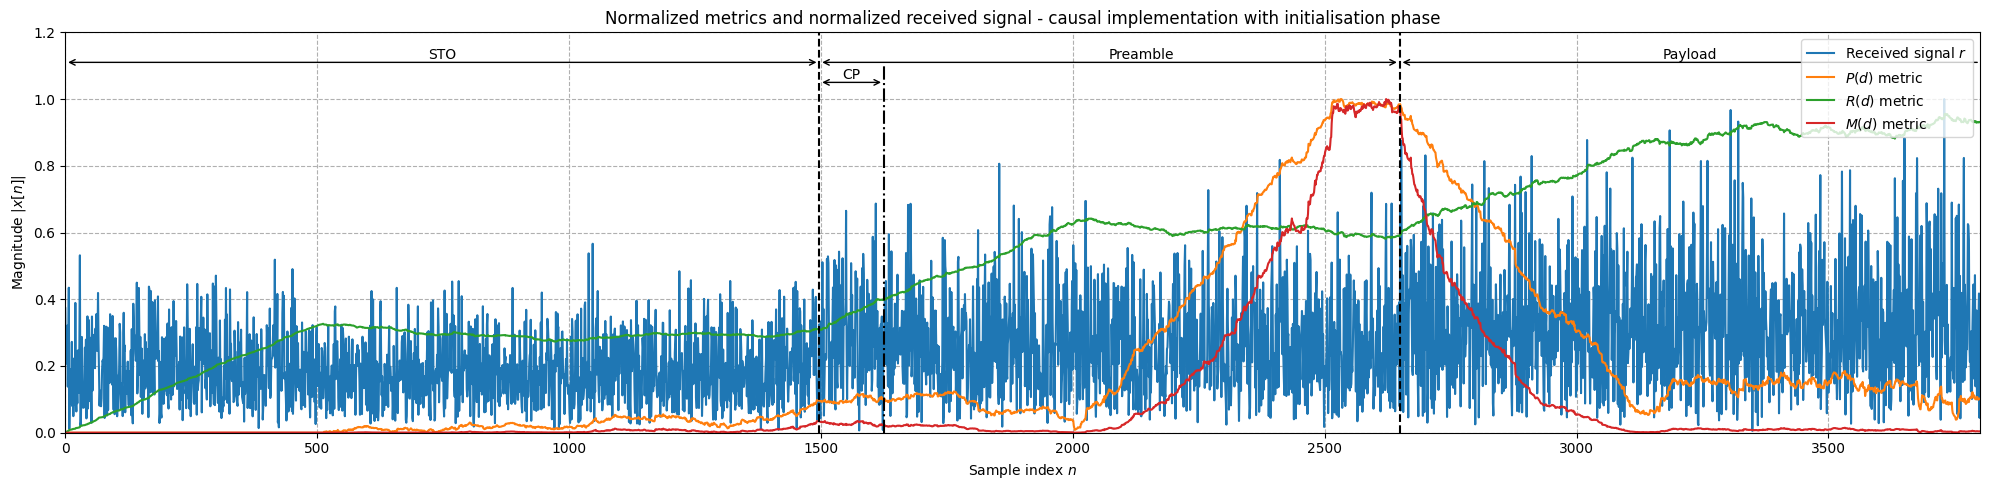

In [20]:
r_norm = r / np.max(abs(r))
P_caus_norm = P_caus / np.max(abs(P_caus))
R_caus_norm = R_caus / np.max(abs(R_caus))
M_caus_norm = M_caus / np.max(abs(M_caus))

plt.figure(figsize=(20, 5))
plt.title("Normalized metrics and normalized received signal - causal implementation with initialisation phase")
plot_metrics_on_labelled_figure(r_norm, P_caus_norm, R_caus_norm, M_caus_norm, sto, ofdm)
plt.tight_layout()

plt.savefig(folder + "metrics_causal_initialisation.pdf")

### Synchronization point calculation

We see that the final metric $M(d)$ has a plateau with a width equal to the cyclic prefix.
When performed in hardware, an easy way to detect and to choose the synchronization point is to use a threshold on the metric $M(d)$. We then must ensure that the metric keeps a high value for a duration at least equal to the cyclic prefix. Then, we could use:
- the middle point between the first sample and the last sample that goes over the threshold as the synchronization point.
- the first sample that goes over the threshold as the synchronization point.
- the last sample that goes over the threshold as the synchronization point.

In [21]:
threshold = 0.85

# Detection algorithm (FSM)
sync_index = 0
detection_entry = 0
detection_exit = 0
detection_valid = False
detecting = False
for i in range(len(M_caus_norm)):
    if M_caus_norm[i] > threshold and not detecting:
        print(f"Metric above threshold at d = {i}")
        detection_entry = i
        detecting = True
    elif M_caus_norm[i] < threshold and detecting:
        print(f"Metric below threshold at d = {i}. Stopping detection.")
        detection_exit = i
        detecting = False
        if detection_exit - detection_entry >= ofdm.CP:
            print(f"Valid detection from d = {detection_entry} to d = {detection_exit}")
            detection_valid = True
            break
        
if detection_valid:
    sync_index = detection_entry + (detection_exit - detection_entry) // 2
    print(f"Sync index at d = {sync_index}")

Metric above threshold at d = 2503
Metric below threshold at d = 2507. Stopping detection.
Metric above threshold at d = 2508
Metric below threshold at d = 2509. Stopping detection.
Metric above threshold at d = 2511
Metric below threshold at d = 2660. Stopping detection.
Valid detection from d = 2511 to d = 2660
Sync index at d = 2585


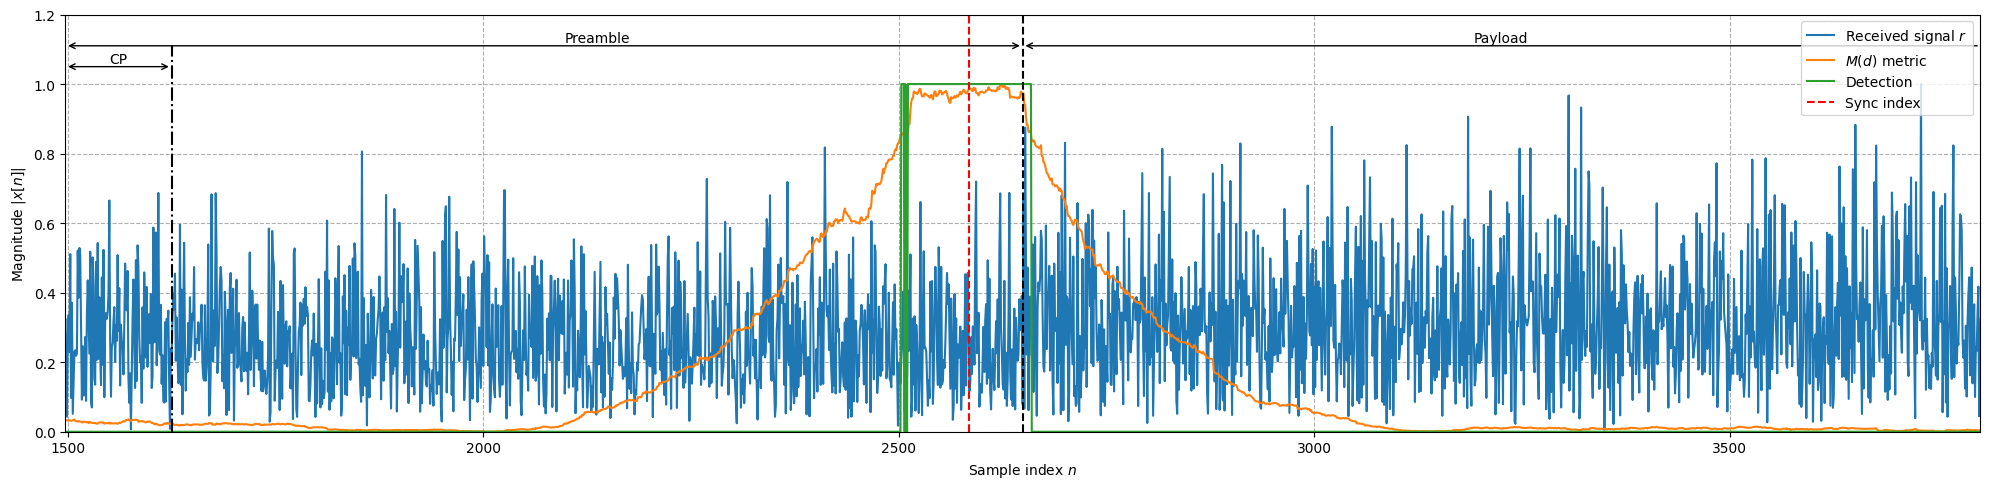

In [22]:
detection = M_caus_norm > threshold

plt.figure(figsize=(20, 5))
plt.plot(np.abs(r_norm), label="Received signal $r$")
plt.plot(np.abs(M_caus_norm), label="$M(d)$ metric")
plt.plot(detection, label="Detection")
plt.axvline(x=sync_index, linestyle='--', color='red', label="Sync index")
plt.legend(loc='upper right')
plt.xlabel("Sample index $n$")
plt.ylabel("Magnitude $|x[n]|$")
plt.xlim(sto, sto + 2 * ofdm.CP + 2 * ofdm.K)
plt.ylim(0, 1.2)

# Preamble annotation
plt.text(sto + ofdm.CP + ofdm.K // 2, 1.12, "Preamble", horizontalalignment='center')
plt.annotate("", xy=(sto + ofdm.CP + ofdm.K, 1.11), xytext=(sto, 1.11), arrowprops=dict(arrowstyle="<->"))
plt.axvline(x=sto + ofdm.CP + ofdm.K, linestyle='--', color='black')

# Cyclic prefix in preamble annotation
plt.text(sto + ofdm.CP // 2, 1.06, "CP", horizontalalignment='center')
plt.annotate("", xy=(sto + ofdm.CP, 1.05), xytext=(sto, 1.05), arrowprops=dict(arrowstyle="<->"))
plt.vlines(x=sto + ofdm.CP, ymin=0, ymax=1.11, linestyle='-.', color='black')

# Payload annotation
plt.text(sto + ofdm.CP + ofdm.K + (ofdm.CP + ofdm.K) // 2, 1.12, "Payload", horizontalalignment='center')
plt.annotate("", xy=(sto + 2 * ofdm.CP + 2 * ofdm.K, 1.11), xytext=(sto + ofdm.CP + ofdm.K, 1.11), arrowprops=dict(arrowstyle="<-"))

plt.grid(True, linestyle='--')
plt.tight_layout()

plt.savefig(folder + "detection.pdf")


### Evaluation of the $M(d)$ metric magnitude

The magnitude of the metric $M(d)$ is not trivial to evaluate. We can see that the metric $M(d)$ is a ratio of the cross-correlation between the first and the second half of the preamble and the energy of the second half of the preamble.

We will here plot the metric $M(d)$ for a given noise level.

In [23]:
def calc_P_R_M(r: np.ndarray) -> list[np.ndarray]:
    ## Keeping in memory the last 2L samples of the received signal and calculating the metrics
    metric_size = len(r) - 2 * ofdm.L
    d_set = np.arange(0, metric_size)

    # P(d) metric - initialization at 0
    P_caus = np.zeros(metric_size, dtype=complex)
    for d in d_set[:-1]:
        p_d_minus_L = r[d - ofdm.L] if d - ofdm.L >= 0 else 0j
        p_d_minus_2L = r[d - 2 * ofdm.L] if d - 2 * ofdm.L >= 0 else 0j
        P_caus[d + 1] = P_caus[d] + np.conj(p_d_minus_L) * r[d] - np.conj(p_d_minus_2L) * p_d_minus_L
        
    # R(d) metric
    R_caus = np.zeros(metric_size, dtype=complex)
    for d in d_set[:-1]:
        r_d_minus_L = r[d - ofdm.L] if d - ofdm.L >= 0 else 0j
        R_caus[d + 1] = R_caus[d] + abs(r[d])**2 - abs(r_d_minus_L)**2
        
    # M(d) metric
    M_caus = np.divide(abs(P_caus)**2, R_caus**2, out=np.zeros_like(abs(P_caus)**2, dtype=complex), where=R_caus != 0)
    
    # Throw away the first L samples
    return [P_caus, R_caus, M_caus]


def calc_MeanStd(SNRs, measurments):
    mean = np.array([np.mean(measurments[snr]) for snr in SNRs])
    std = np.array([np.std(measurments[snr]) for snr in SNRs])
    return mean, std

M_dopt = defaultdict(list)
M_doutside = defaultdict(list)
SNRs = np.linspace(-10, 30, 21)
for SNR in SNRs:
    for i in range(100):
        x = generate_OFDM_frame(ofdm)
        sigma_s2 = np.mean(abs(x ** 2))
        sigma_n2 = sigma_s2 * 10 ** (-SNR / 10.)
        sto = 2000
        cfo = 0.05 / ofdm.K
        r = addNoise(addCFO(addSTO(x, sto), cfo), sigma_n2)
        P, R, M = calc_P_R_M(r)
        M_dopt[SNR].append(M[sto + ofdm.K])                 # Begin of plateau at sto + CP + K - CP
        M_doutside[SNR].append(M[sto + ofdm.K + ofdm.CP])   # End of plateau at sto + CP + K


/home/quentin/Documents/Cours/linfo2990/TFE25-462/env/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/quentin/Documents/Cours/linfo2990/TFE25-462/env/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


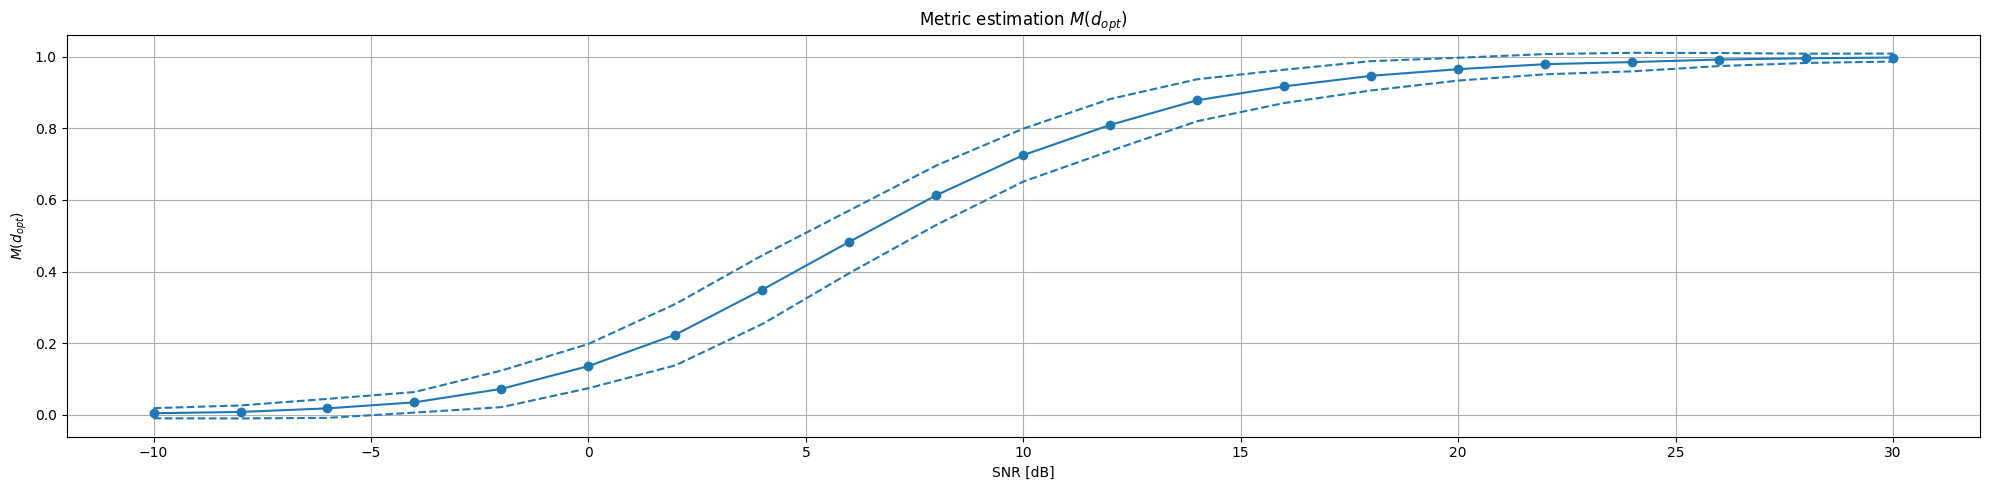

In [24]:

M_dopt_mean, M_dopt_std = calc_MeanStd(SNRs, M_dopt) 
M_doutside_mean, M_doutside_std = calc_MeanStd(SNRs, M_doutside)

plt.figure(figsize=(20, 5))
plt.title('Metric estimation $M(d_{opt})$')

# Plot the measured curves
plt.plot(SNRs, M_dopt_mean, 'o-', label='Mean $M(d_{opt})$', color='#1f77b4')
plt.plot(SNRs, M_dopt_mean + 3*M_dopt_std, '--', color='#1f77b4')
plt.plot(SNRs, M_dopt_mean - 3*M_dopt_std, '--', color='#1f77b4')

plt.xlabel('SNR [dB]')
plt.ylabel('$M(d_{opt})$')
plt.grid(True)
plt.tight_layout()

plt.savefig(folder + "metric_estimation.pdf")

## CFO estimation

The CFO estimation is computed at the synchronization point. The CFO is estimated by computing the phase difference between the first and the second part of the preamble. The CFO is then estimated with the following equation:
$$\hat{\phi} = \angle P(d_{\text{sync}})$$
that can be computed by:
$$\hat{\Delta f} = \hat{\phi}/\pi$$


In [25]:
phi = np.angle(P_caus[sync_index])
delta_f = phi / (np.pi)

print(f"Estimated CFO: {delta_f} Hz")

Estimated CFO: 0.0022241128406315196 Hz
